In [2]:
# Importing libraries
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')
# Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# Linear Regression
from sklearn.linear_model import LinearRegression
# pmdarima
import pmdarima as pm
# Prophet
from fbprophet import Prophet
# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# Cloning JHU CSSE's COVID-19 repository
!git clone https://github.com/CSSEGISandData/COVID-19.git

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [4]:
# Reading data
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.iloc[:,:102] # Selecting data from various countries from January 22, 2020 to April 28, 2020
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,997,1027,1093,1177,1236,1331,1464,1532,1704,1830
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27


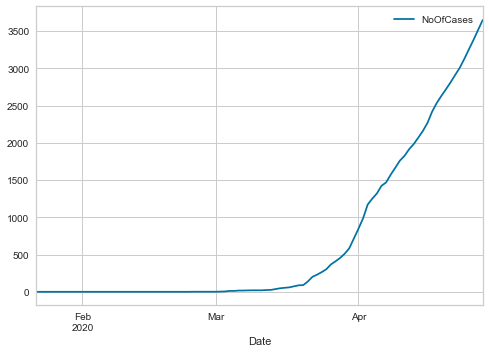

In [5]:
def get_time_series(row_no):
  row = pd.DataFrame(data.iloc[row_no,4:]).reset_index()
  row.columns = ["Date","NoOfCases"]
  row["Date"] = pd.to_datetime(row["Date"])
  return row.set_index('Date')

get_time_series(2).plot()
plt.show()

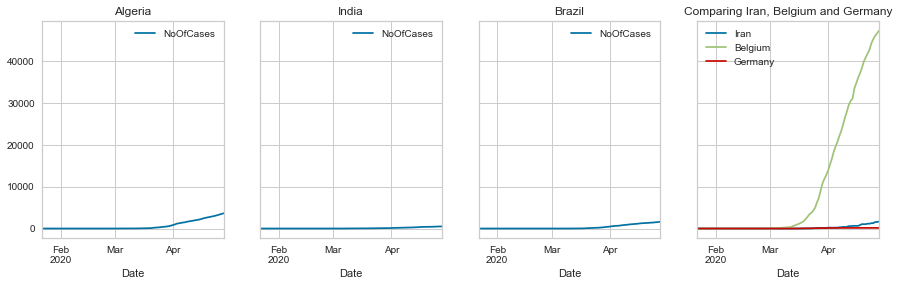

In [6]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4,sharey=True,figsize=(15,4))
get_time_series(2).plot(ax=ax1, title="Algeria")
get_time_series(131).plot(ax=ax2, title="India")
get_time_series(28).plot(ax=ax3, title="Brazil")
multiple_series = pd.concat([get_time_series(133),get_time_series(23),get_time_series(120)],axis=1)
multiple_series.columns = ["Iran","Belgium","Germany"]
multiple_series.plot(ax=ax4, title="Comparing Iran, Belgium and Germany")
plt.show()

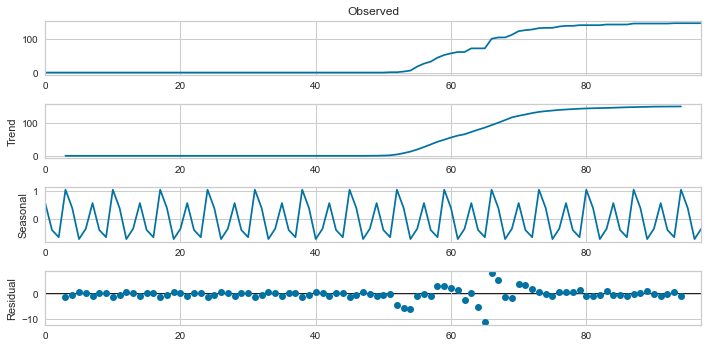

In [7]:
plt.rcParams['figure.figsize'] = [10, 5]
additive_st = seasonal_decompose(get_time_series(120).astype('float32').values,model='additive',freq=7)
additive_st.plot()
plt.show()

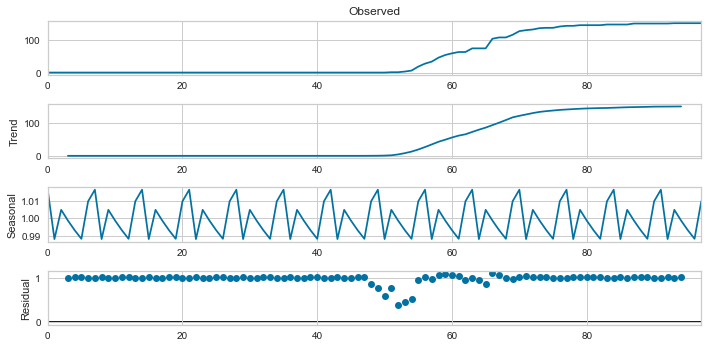

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
multiplicative_st = seasonal_decompose(get_time_series(120).add(1).astype('float32').values,model='multiplicative',freq=7)
# Added 1 to the time series as multiplicative model cannot have zero or negative values 
multiplicative_st.plot()
plt.show()

### A single time series for global confirmed cases

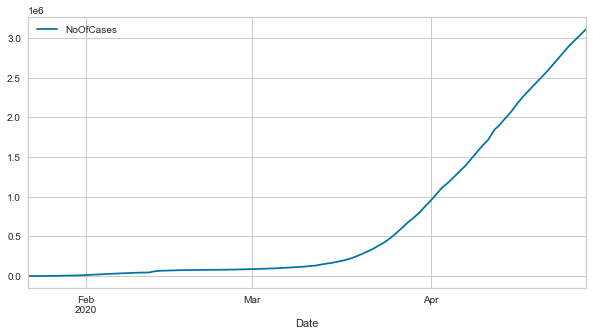

In [9]:
global_ts = data.iloc[:,4:]
global_ts = pd.DataFrame(global_ts.sum(axis=0)).reset_index()
global_ts.columns = ["Date","NoOfCases"]
global_ts["Date"] = pd.to_datetime(global_ts["Date"])
global_ts.set_index('Date', inplace=True)

global_ts.plot()
plt.show()

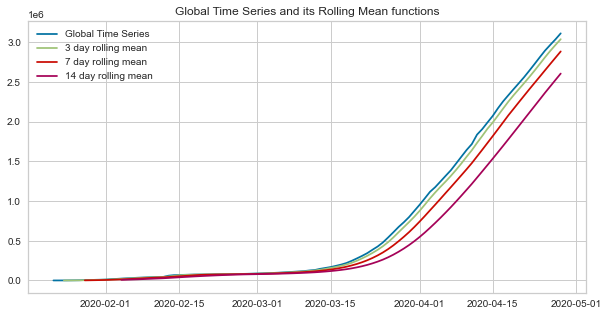

In [10]:
plt.plot(global_ts,label='Global Time Series')
plt.plot(global_ts.rolling(3).mean(),label="3 day rolling mean") # 3 day window
plt.plot(global_ts.rolling(7).mean(),label="7 day rolling mean") # 7 day window
plt.plot(global_ts.rolling(14).mean(),label="14 day rolling mean") # 14 day window
plt.title("Global Time Series and its Rolling Mean functions")
plt.legend(loc=2, ncol=1)
plt.show()

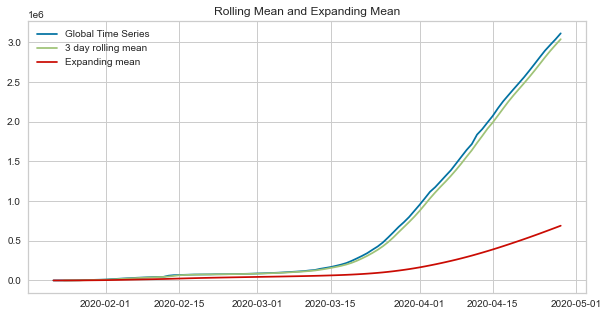

In [11]:
plt.plot(global_ts,label='Global Time Series')
plt.plot(global_ts.rolling(3).mean(),label="3 day rolling mean") # 3 day window
plt.plot(global_ts.expanding().mean(),label="Expanding mean") # Expanding Mean
plt.title("Rolling Mean and Expanding Mean")
plt.legend(loc=2, ncol=1)
plt.show()

### Time Series Clustering

In [12]:
data_by_country = data.groupby("Country/Region").agg('sum').reset_index() # Data grouped by countries to create clusters at country level
data_by_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,...,997,1027,1093,1177,1236,1331,1464,1532,1704,1830
1,Albania,41.15330,20.168300,0,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27


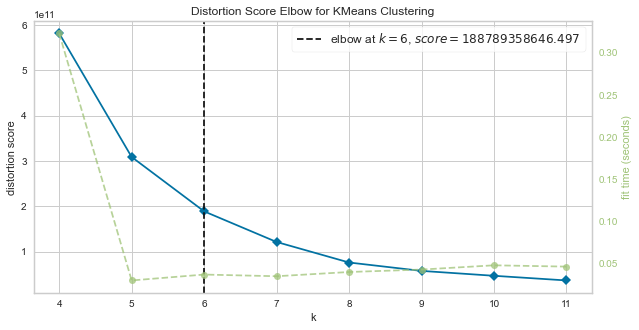

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k=(4,12),metric="distortion") # Iterating over 4 to 12 clusters with 'distortion' metric
visualizer.fit(data_by_country.iloc[:,3:])
visualizer.show()

In [14]:
# Clustering with 6 clusters
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=0) # Defining the moodel 
y_kmeans = kmeans.fit_predict(data_by_country.iloc[:,3:]) # Estimating clusters

data_by_country["Cluster"] = y_kmeans # Assigning cluster number to individual countries

data_by_country["Cluster"].value_counts()

0    176
4      8
5      3
2      2
1      1
3      1
Name: Cluster, dtype: int64

168 countries belong to Cluster `0` while clusters `1` and `3` have one country each.

In [15]:
for i in range(1,6):
  print("Countries in cluster {} are {}".format(i,list(data_by_country[data_by_country.Cluster==i]["Country/Region"].unique())))

Countries in cluster 1 are ['US']
Countries in cluster 2 are ['Italy', 'Spain']
Countries in cluster 3 are ['China']
Countries in cluster 4 are ['Belgium', 'Brazil', 'Canada', 'Iran', 'Netherlands', 'Russia', 'Switzerland', 'Turkey']
Countries in cluster 5 are ['France', 'Germany', 'United Kingdom']


In [16]:
# For generating 95% confidence interval 
def get_cluster_intervals(cluster):
  df = pd.DataFrame()
  df["mean"] = cluster.mean(axis=0)
  df["lower_bound"] = df["mean"] - (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
  df["upper_bound"] = df["mean"] + (1.96 * cluster.std(axis=0))/np.sqrt(len(df["mean"]))
  df.index = global_ts.index
  return df

cluster4 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==4].iloc[:,3:-1])
cluster0 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==0].iloc[:,3:-1])
cluster2 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==2].iloc[:,3:-1])
cluster5 = get_cluster_intervals(data_by_country[data_by_country["Cluster"]==5].iloc[:,3:-1])
cluster1 = data_by_country[data_by_country["Cluster"]==1].iloc[:,3:-1].values
cluster3 = data_by_country[data_by_country["Cluster"]==3].iloc[:,3:-1].values

The following plot shows average cases for Cluster `0`:

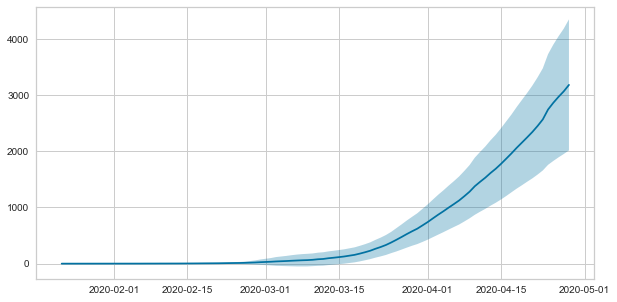

In [17]:
fig, ax = plt.subplots()
ax.plot(cluster0.index,cluster0["mean"])
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
plt.show()

The following plot shows all clusters except the U.S. and China with 95% confidence intervals. Differences in the trends of the four clusters is very significant.

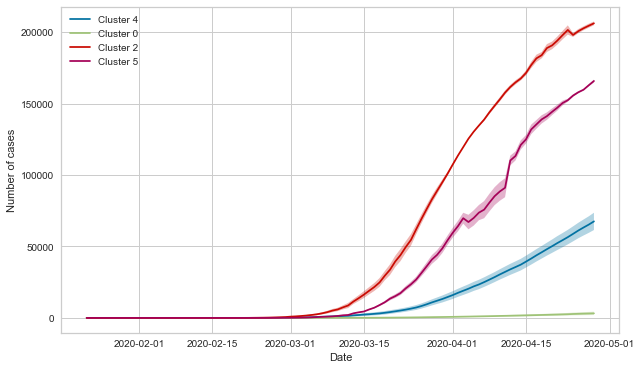

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cluster4.index,cluster4["mean"],label="Cluster 4")
ax.fill_between(cluster4.index, cluster4["lower_bound"], cluster4["upper_bound"], alpha=.3)
ax.plot(cluster0.index,cluster0["mean"],label="Cluster 0")
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
ax.plot(cluster2.index,cluster2["mean"],label="Cluster 2")
ax.fill_between(cluster2.index, cluster2["lower_bound"], cluster2["upper_bound"], alpha=.3)
ax.plot(cluster5.index,cluster5["mean"],label="Cluster 5")
ax.fill_between(cluster5.index, cluster5["lower_bound"], cluster5["upper_bound"], alpha=.3)
#ax.plot(global_ts.index,cluster1.flatten(),label="Cluster 1 - U.S.")
#ax.plot(global_ts.index,cluster3.flatten(),label="Cluster 3 - China")
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

The following plot shows all six clusters. China has a unique plot where cases become nearly constant from around February 15. The U.S. clearly has a separate cluster due to high number of cumulative cases. 

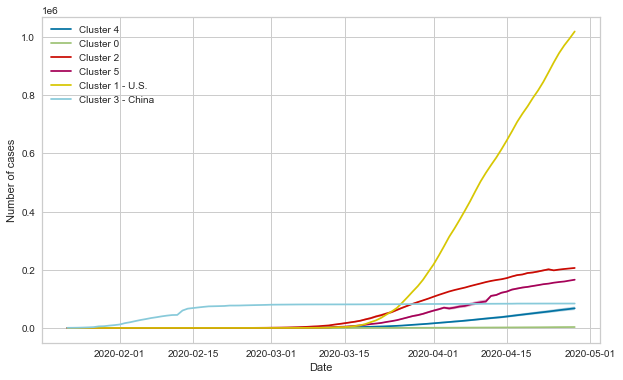

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(cluster4.index,cluster4["mean"],label="Cluster 4")
ax.fill_between(cluster4.index, cluster4["lower_bound"], cluster4["upper_bound"], alpha=.3)
ax.plot(cluster0.index,cluster0["mean"],label="Cluster 0")
ax.fill_between(cluster0.index, cluster0["lower_bound"], cluster0["upper_bound"], alpha=.3)
ax.plot(cluster2.index,cluster2["mean"],label="Cluster 2")
ax.fill_between(cluster2.index, cluster2["lower_bound"], cluster2["upper_bound"], alpha=.3)
ax.plot(cluster5.index,cluster5["mean"],label="Cluster 5")
ax.fill_between(cluster5.index, cluster5["lower_bound"], cluster5["upper_bound"], alpha=.3)
ax.plot(global_ts.index,cluster1.flatten(),label="Cluster 1 - U.S.")
ax.plot(global_ts.index,cluster3.flatten(),label="Cluster 3 - China")
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()

### Time Series Modelling

In [20]:
# Creating a training and test set to predict 7 days into the future
train = global_ts.iloc[:-7,:]
test = global_ts.iloc[-7:,:]

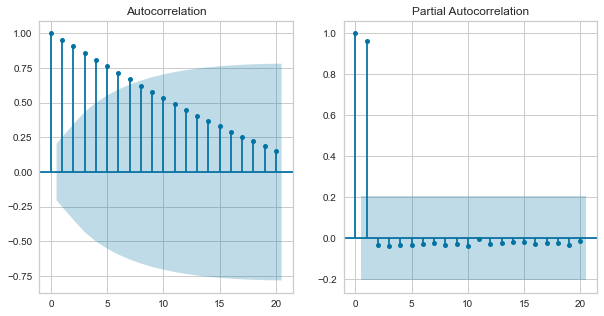

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(train.iloc[:,0].values, ax=axes[0])
plot_pacf(train.iloc[:,0].values, ax=axes[1])
plt.show()

In [22]:
series = train.iloc[:,0]
for i in range(0,4):
  print("p-value after differencing {} times: {}".format(i,adfuller(series)[1]))
  series = series.diff().dropna()

p-value after differencing 0 times: 0.11299975583438587
p-value after differencing 1 times: 0.9530218511877165
p-value after differencing 2 times: 3.7240400494425457e-16
p-value after differencing 3 times: 5.715864681119015e-14


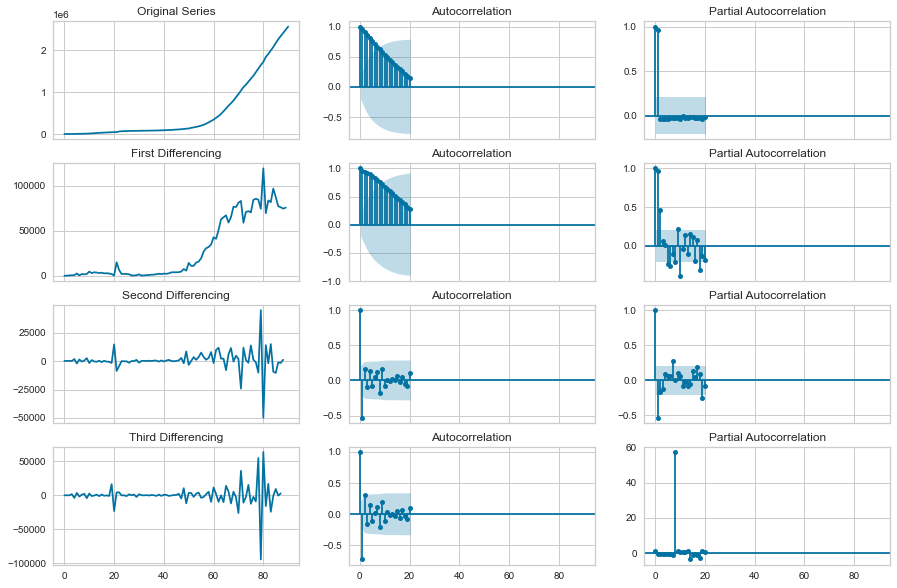

In [23]:
fig, axes = plt.subplots(4, 3, figsize=(15,10), sharex=True)
axes[0, 0].plot(train.iloc[:,0].values)
axes[0, 0].set_title('Original Series')
plot_acf(train.iloc[:,0].values, ax=axes[0, 1])
plot_pacf(train.iloc[:,0].values, ax=axes[0, 2])
axes[1, 0].plot(train.iloc[:,0].diff().dropna().values)
axes[1, 0].set_title('First Differencing')
plot_acf(train.iloc[:,0].diff().dropna().values, ax=axes[1, 1])
plot_pacf(train.iloc[:,0].diff().dropna().values, ax=axes[1, 2])
axes[2, 0].plot(train.iloc[:,0].diff().diff().dropna().values)
axes[2, 0].set_title('Second Differencing')
plot_acf(train.iloc[:,0].diff().diff().dropna().values, ax=axes[2, 1])
plot_pacf(train.iloc[:,0].diff().diff().dropna().values, ax=axes[2, 2])
axes[3, 0].plot(train.iloc[:,0].diff().diff().diff().dropna().values)
axes[3, 0].set_title('Third Differencing')
plot_acf(train.iloc[:,0].diff().diff().diff().dropna().values, ax=axes[3, 1])
plot_pacf(train.iloc[:,0].diff().diff().diff().dropna().values, ax=axes[3, 2])
plt.show()

From the above plot, the best model we can make is `ARIMA(1,2,1)`.

In [24]:
modelArima121 = ARIMA(train.values,order=(1,2,1)) # p=1, d=2, q=1
modelArima121_fit = modelArima121.fit(disp=0)  
print(modelArima121_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   89
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -920.628
Method:                       css-mle   S.D. of innovations           7502.597
Date:                Mon, 28 Dec 2020   AIC                           1849.255
Time:                        14:36:38   BIC                           1859.210
Sample:                             2   HQIC                          1853.267
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        862.1709    419.032      2.058      0.040      40.883    1683.459
ar.L1.D2.y    -0.3047      0.161     -1.889      0.059      -0.621       0.011
ma.L1.D2.y    -0.3181      0.154     -2.064      0.0

In [25]:
# A function to get results from ARIMA models
def get_arima_results(order,train,test,prints=True):
  history = train.values
  pred = []
  for i in range(len(test)):
    model = ARIMA(history,order=order)
    fitted = model.fit(disp=0)
    y_pred = fitted.forecast()[0]
    pred.append(y_pred)
    history = np.append(history,y_pred).reshape(history.shape[0]+1,-1)
  if prints:
    print(fitted.summary())
  rmse = np.sqrt(mean_squared_error(test.values,np.array(pred)))
  mae = mean_absolute_error(test.values,np.array(pred))
  mape = mean_absolute_percentage_error(test.values,np.array(pred))
  aic = fitted.aic
  bic = fitted.bic
  return rmse, mae, mape, aic, bic

# Using above function we can iterate over ARIMA models of different orders to get the best model
arima_results = {}
for i in tqdm([0,1,2,3,4]):
  for j in [0,1,2]:
    for k in [0,1,2,3,4,]:
      try:
        order = "("+str(i)+","+str(j)+","+str(k)+")"
        rmse, mae, mape, aic, bic = get_arima_results((i,j,k),train,test,prints=False)
        arima_results[order] = [rmse, mae, mape, aic, bic]
      except:
        pass
    
arima_results = pd.DataFrame(arima_results).T.reset_index()
arima_results.columns = ["Order","RMSE","MAE","MAPE","AIC","BIC"]

100%|██████████| 5/5 [01:11<00:00, 14.38s/it]


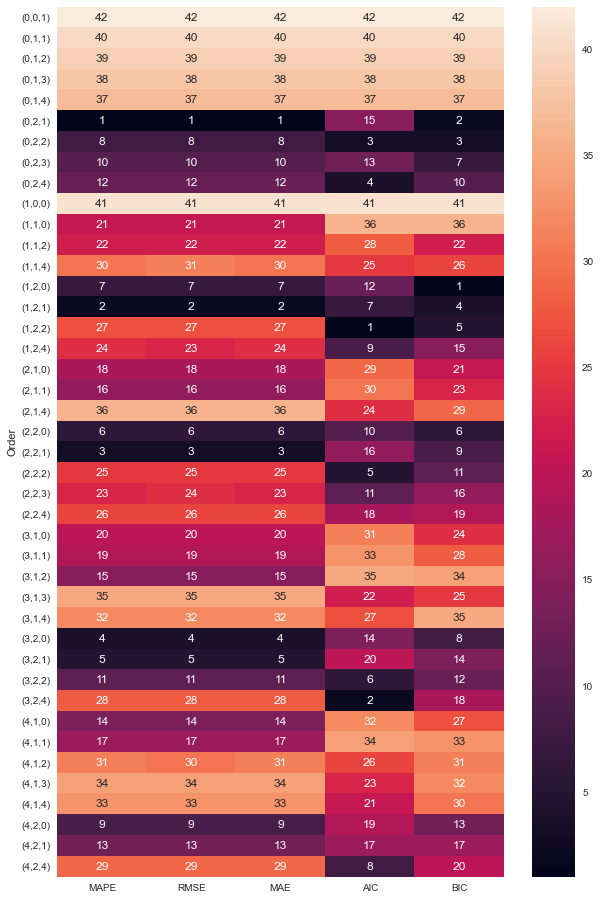

In [26]:
# Ranking different metrics
arima_heatmap = pd.DataFrame()
arima_heatmap["Order"] = arima_results["Order"]
arima_heatmap["MAPE"] = arima_results["MAPE"].rank(method="max")
arima_heatmap["RMSE"] = arima_results["RMSE"].rank(method="max")
arima_heatmap["MAE"] = arima_results["MAE"].rank(method="max")
arima_heatmap["AIC"] = arima_results["AIC"].rank(method="max")
arima_heatmap["BIC"] = arima_results["BIC"].rank(method="max")

# Generating a heatmap to get best results
fig,ax = plt.subplots(figsize=(10,16))
sns.heatmap(arima_heatmap.set_index("Order"),annot=True,ax=ax)
plt.show()

In [27]:
print("Best ranked model on the basis of metrics MAE, RMSE and MAPE")
arima_results[arima_results["Order"]=="(4,2,3)"]

Best ranked model on the basis of metrics MAE, RMSE and MAPE


,Order,RMSE,MAE,MAPE,AIC,BIC


In [28]:
print("Best ranked model on the basis of AIC")
arima_results[arima_results["Order"]=="(4,2,4)"]

Best ranked model on the basis of AIC


,Order,RMSE,MAE,MAPE,AIC,BIC
41,"(4,2,4)",39449.320385,36376.550745,1.236984,1967.2604,1992.799169


In [29]:
print("Best ranked model on the basis of BIC")
arima_results[arima_results["Order"]=="(0,2,1)"]

Best ranked model on the basis of BIC


,Order,RMSE,MAE,MAPE,AIC,BIC
5,"(0,2,1)",10855.753265,9832.50512,0.337746,1968.605355,1976.266986


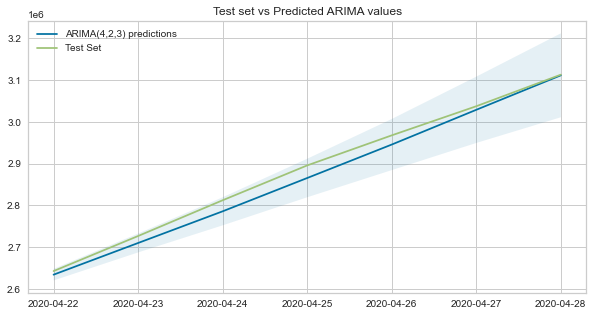

In [30]:
modelArima423 = ARIMA(train.values,order=(4,2,3))
modelArima423_fit = modelArima423.fit(disp=0)  
forecast423 = modelArima423_fit.forecast(7)
plt.plot(test.index,forecast423[0],label="ARIMA(4,2,3) predictions")
plt.fill_between(test.index,[i[0] for i in forecast423[2].tolist()],[i[1] for i in forecast423[2].tolist()], alpha=0.1)
plt.plot(test, label="Test Set")
plt.title("Test set vs Predicted ARIMA values")
plt.legend(loc=2)
plt.show()

For now, the best model is of the order `(4,2,3)` as it is ranked first for three out of five metrics

#### Auto Arima
`pmdarima` package provides the `auto_arima` model that automatically returns the best model parameters

In [31]:
model = pm.auto_arima(train.values, start_p=1, start_q=1, test='adf',max_p=3, max_q=3,
                      m=7, d=None, seasonal=True, start_P=0, D=None, trace=True, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1850.290, Time=1.20 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1876.013, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1850.378, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1851.567, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1850.786, Time=0.02 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1850.979, Time=0.08 sec
 ARIMA(1,2,1)(0,0,2)[7]             : AIC=1851.149, Time=0.09 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=1849.858, Time=0.05 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1850.859, Time=0.12 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=1852.797, Time=0.16 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1851.099, Time=0.06 sec
 ARIMA(2,2,1)(1,0,0)[7]             : AIC=1851.802, Time=0.06 sec
 ARIMA(1,2,2)(1,0,0)[7]             : AIC=1848.233, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=1846.981, Time=0.07 sec
 ARIMA(1,2,2)(0,0,1)[7]          

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -919.490
Date:                Mon, 28 Dec 2020   AIC                           1846.981
Time:                        14:38:41   BIC                           1856.935
Sample:                             0   HQIC                          1850.993
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7943      0.124      6.412      0.000       0.552       1.037
ma.L1         -1.4522      0.130    -11.163      0.000      -1.707      -1.197
ma.L2          0.6523      0.097      6.691      0.0

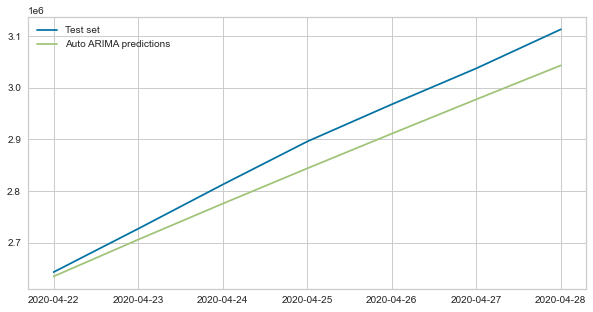

In [32]:
print(model.summary()) # best model
model.fit(train.values)  # Fitting model
preds = model.predict(n_periods=7) # Making predictions for next 7 days i.e., the test set
print("Root Mean Squared Error for best model: {}".format(np.sqrt(mean_squared_error(test.values,preds))))
print("Mean Absolute Error for best model: {}".format(mean_absolute_error(test.values,preds)))
print("Mean Absolute Percentage Error for best model: {}".format(mean_absolute_percentage_error(test.values,preds)))
plt.plot(test, label="Test set")
plt.plot(test.index,preds, label="Auto ARIMA predictions")
plt.legend()
plt.show()

In [33]:
lr_global = global_ts.reset_index()

# Lag features of last 
for i in range(1,15):
  lr_global["lag{}".format(i)] = lr_global["NoOfCases"].shift(i)

# Date based features
lr_global["day"] = lr_global["Date"].dt.day
lr_global["month"] = lr_global["Date"].dt.month

# Moving average based features
lr_global["rolling_7_mean"] = lr_global["NoOfCases"].rolling(7).mean()
lr_global["rolling_14_mean"] = lr_global["NoOfCases"].rolling(14).mean()
lr_global["rolling_7_std"] = lr_global["NoOfCases"].rolling(7).std()
lr_global["rolling_14_std"] = lr_global["NoOfCases"].rolling(14).std()
lr_global["rolling_7_var"] = lr_global["NoOfCases"].rolling(7).var()
lr_global["rolling_14_var"] = lr_global["NoOfCases"].rolling(14).var()

lr_global.tail()

,Date,NoOfCases,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag13,lag14,day,month,rolling_7_mean,rolling_14_mean,rolling_7_std,rolling_14_std,rolling_7_var,rolling_14_var
93,2020-04-24,2812325,2726775.0,2642885.0,2561192.0,2485347.0,2410704.0,2334507.0,2257225.0,2169593.0,...,1718073.0,1643587.0,24,4,2.567676e+06,2.280470e+06,171585.798035,344851.708310,2.944169e+10,1.189227e+11
94,2020-04-25,2895703,2812325.0,2726775.0,2642885.0,2561192.0,2485347.0,2410704.0,2334507.0,2257225.0,...,1837439.0,1718073.0,25,4,2.647847e+06,2.364587e+06,175542.967827,340718.452868,3.081533e+10,1.160891e+11
95,2020-04-26,2967633,2895703.0,2812325.0,2726775.0,2642885.0,2561192.0,2485347.0,2410704.0,2334507.0,...,1907058.0,1837439.0,26,4,2.727409e+06,2.445315e+06,176355.691304,340101.754279,3.110133e+10,1.156692e+11
96,2020-04-27,3037310,2967633.0,2895703.0,2812325.0,2726775.0,2642885.0,2561192.0,2485347.0,2410704.0,...,1990793.0,1907058.0,27,4,2.806260e+06,2.526047e+06,173459.775633,336633.763721,3.008829e+10,1.133223e+11
97,2020-04-28,3112818,3037310.0,2967633.0,2895703.0,2812325.0,2726775.0,2642885.0,2561192.0,2485347.0,...,2072667.0,1990793.0,28,4,2.885064e+06,2.606192e+06,168808.863707,332943.595377,2.849643e+10,1.108514e+11


In [34]:
# Training and test sets for Linear Model
# Starting from 15th observation as first 14 rows have null values due to lag and moving average features
lr_train = lr_global.iloc[14:-7,:]
lr_test = lr_global.iloc[-7:,:]

lr_train.set_index("Date",inplace=True)
lr_test.set_index("Date",inplace=True)

In [35]:
reg = LinearRegression().fit(lr_train.drop(["NoOfCases"],axis=1), lr_train["NoOfCases"]) # fitting the lr model
lr_preds = reg.predict(lr_test.drop(["NoOfCases"],axis=1)) # getting predictions

In [36]:
print("Root Mean Squared Error for best model: {:.6f}".format(np.sqrt(mean_squared_error(lr_test["NoOfCases"].values,lr_preds))))
print("Mean Absolute Error for best model: {:.6f}".format(mean_absolute_error(lr_test["NoOfCases"].values,lr_preds)))
print("Mean Absolute Percentage Error for best model: {:.11f}".format(mean_absolute_percentage_error(lr_test["NoOfCases"].values,lr_preds)))

Root Mean Squared Error for best model: 0.000001
Mean Absolute Error for best model: 0.000001
Mean Absolute Percentage Error for best model: 0.00000000003



### Time Series Cross Validation



In [37]:
train_13w = train # Training for 13 weeks
train_11w = train[7*2:] # Training for 11 weeks
train_9w = train[7*4:] # Training for 9 weeks
train_7w = train[7*6:] # Training for 7 weeks
train_5w = train[7*8:] # Training for 5 weeks
pred_list = []
rmse_list = []
mae_list = []
mape_list = []
week = 13
for i in tqdm([train_13w,train_11w,train_9w,train_7w,train_5w]):
  model = pm.auto_arima(train.values, start_p=1, start_q=1, test='adf',max_p=3, max_q=3,
                      m=7, d=None, seasonal=True, start_P=0, D=None, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=True)
  model.fit(i.values)
  preds = model.predict(n_periods=7)
  pred_list.append(preds)
  rmse = np.sqrt(mean_squared_error(test.values,preds))
  mae = mean_absolute_error(test.values,preds)
  mape = mean_absolute_percentage_error(test.values,preds)
  print(" Root Mean Squared Error by training on {} weeks: {}".format(week,rmse))
  print(" Mean Absolute Error by training on {} weeks: {}".format(week,mae))
  print(" Mean Absolute Percentage Error by training on {} weeks: {}".format(week,mape))
  week = week-2
  rmse_list.append(rmse)
  mae_list.append(mae)
  mape_list.append(mape)
print("\nAverage mean_absolute_percentage_error: {}".format(np.mean(rmse_list)))
print("mean_absolute_percentage_error after averaging predictions: {}".format(np.sqrt(mean_squared_error(test.values,np.mean(pred_list,axis=0)))))
print("Average mean_absolute_error: {}".format(np.mean(mae_list)))
print("mean_absolute_error after averaging predictions: {}".format(mean_absolute_error(test.values,np.mean(pred_list,axis=0))))
print("Average mean_absolute_percentage_error: {}".format(np.mean(mape_list)))
print("mean_absolute_percentage_error after averaging predictions: {}".format(mean_absolute_percentage_error(test.values,np.mean(pred_list,axis=0))))

 20%|██        | 1/5 [00:01<00:06,  1.72s/it]

 Root Mean Squared Error by training on 13 weeks: 48213.634139256596
 Mean Absolute Error by training on 13 weeks: 43556.08392132865
 Mean Absolute Percentage Error by training on 13 weeks: 5.981374517128032


 40%|████      | 2/5 [00:03<00:05,  1.72s/it]

 Root Mean Squared Error by training on 11 weeks: 39395.063461773214
 Mean Absolute Error by training on 11 weeks: 35675.9345901959
 Mean Absolute Percentage Error by training on 11 weeks: 6.032340044317755


 60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

 Root Mean Squared Error by training on 9 weeks: 21453.73116314321
 Mean Absolute Error by training on 9 weeks: 20033.492589771417
 Mean Absolute Percentage Error by training on 9 weeks: 6.208530050725393


 80%|████████  | 4/5 [00:06<00:01,  1.74s/it]

 Root Mean Squared Error by training on 7 weeks: 21069.25005459726
 Mean Absolute Error by training on 7 weeks: 19660.413572583213
 Mean Absolute Percentage Error by training on 7 weeks: 6.210816167629006


100%|██████████| 5/5 [00:08<00:00,  1.76s/it]

 Root Mean Squared Error by training on 5 weeks: 11517.59182952671
 Mean Absolute Error by training on 5 weeks: 9354.519670563217
 Mean Absolute Percentage Error by training on 5 weeks: 6.2911779050444965

Average mean_absolute_percentage_error: 28329.854129659398
mean_absolute_percentage_error after averaging predictions: 27610.587624570795
Average mean_absolute_error: 25656.08886888848
mean_absolute_error after averaging predictions: 25638.98428233979
Average mean_absolute_percentage_error: 6.144847736968936
mean_absolute_percentage_error after averaging predictions: 6.144769238567674




#### Facebook Prophet


In [38]:
fbp_train = train.reset_index()
fbp_train.columns = ["ds","y"] # Specific column names are required
fbp_model = Prophet(daily_seasonality=True)
fbp_model.fit(fbp_train)

future = fbp_model.make_future_dataframe(periods=7) # Forecasting for last 7 days
forecast = fbp_model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Root Mean Squared Error for Prophet model: 13470.868804464077
Mean Absolute Error for Prophet model: 10236.737788666638
Mean Absolute Percentage Error for Prophet model: 6.4186278279752


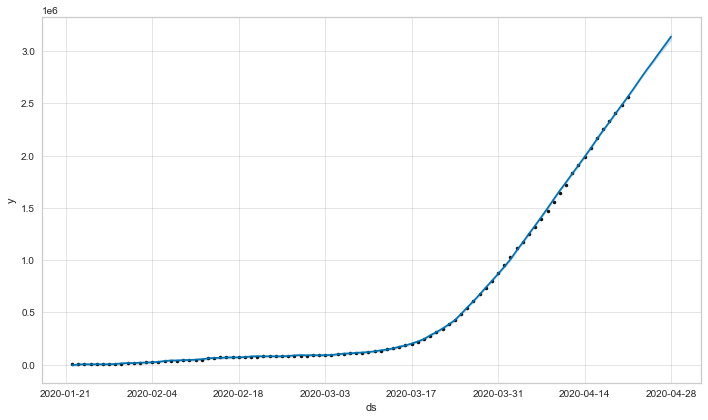

In [39]:
print("Root Mean Squared Error for Prophet model: {}".format(np.sqrt(mean_squared_error(test.values,forecast.tail(7)["yhat"].values))))
print("Mean Absolute Error for Prophet model: {}".format(mean_absolute_error(test.values,forecast.tail(7)["yhat"].values)))
print("Mean Absolute Percentage Error for Prophet model: {}".format(mean_absolute_percentage_error(test.values,forecast.tail(7)["yhat"].values)))
fig = fbp_model.plot(forecast)

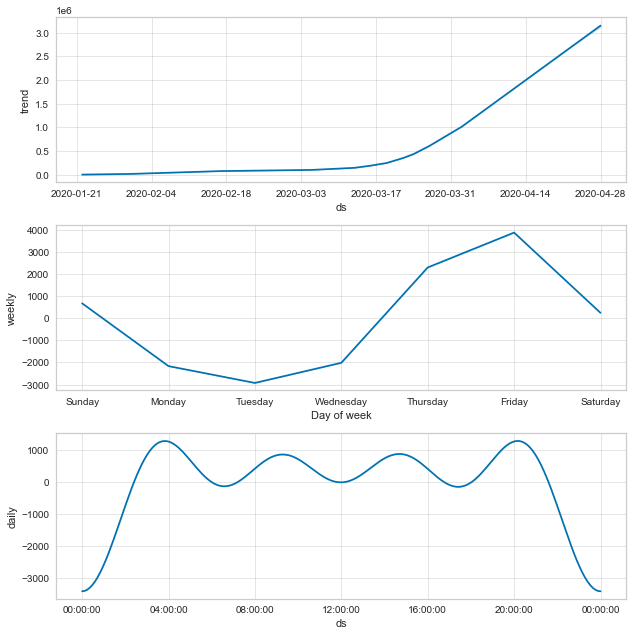

In [40]:
fig = fbp_model.plot_components(forecast)



### Multiple Time Series Forecasting


In [41]:
c2 = data_by_country[data_by_country["Cluster"]==2].set_index("Country/Region").iloc[:,2:-1].T.reset_index()
c2["Date"] = pd.to_datetime(c2["index"])
c2.drop(["index"],axis=1,inplace=True)
c2.set_index("Date",inplace=True)

c2_train = c2.iloc[:-7,:]
c2_test = c2.iloc[-7:,:]

In [50]:
c2_test

Country/Region,Italy,Spain
Date,,
2020-04-22,187327,208389
2020-04-23,189973,213024
2020-04-24,192994,202990
2020-04-25,195351,205905
2020-04-26,197675,207634
2020-04-27,199414,209465
2020-04-28,201505,210773


In [42]:
best_model = {
    "best_rmse": [float("inf"),(0,0)],
    "best_mae": [float("inf"),(0,0)],
    "best_mape": [float("inf"),(0,0)],
    "best_aic": [float("inf"),(0,0)],
    "best_bic": [float("inf"),(0,0)]
}
# Iterative approach to find best model
for i in tqdm(range(1,5)): # Taking all AR and MA parameter combination from 1 to 4
  for j in range(1,5):
    if i == 0 and j== 0:
      pass
    else:
      mod = sm.tsa.VARMAX(c2_train.astype('float32'), order=(i,j), trend='t')
      res = mod.fit(maxiter=100, disp=False)
      varmax_forecast = res.forecast(7)
      varmax_rmse = np.sqrt(mean_squared_error(c2_test.values.flatten(),varmax_forecast.values.flatten()))
      varmax_mae = mean_absolute_error(c2_test.values.flatten(),varmax_forecast.values.flatten())
      varmax_mape = mean_absolute_percentage_error(c2_test.values.flatten(),varmax_forecast.values.flatten())
      varmax_aic = res.aic
      varmax_bic = res.bic
      if varmax_rmse < best_model["best_rmse"][0]:
        best_model["best_rmse"] = [varmax_rmse,(i,j)]
      if varmax_mae < best_model["best_mae"][0]:
        best_model["best_mae"] = [varmax_mae,(i,j)]
      if varmax_mape < best_model["best_mape"][0]:
        best_model["best_mape"] = [varmax_mape,(i,j)]
      if varmax_aic < best_model["best_aic"][0]:
        best_model["best_aic"] = [varmax_aic,(i,j)]
      if varmax_bic < best_model["best_bic"][0]:
        best_model["best_bic"] = [varmax_bic,(i,j)]
    print(best_model)

  0%|          | 0/4 [00:00<?, ?it/s]

{'best_rmse': [14312.205224025236, (1, 1)], 'best_mae': [12353.462521246534, (1, 1)], 'best_mape': [6.211055579672619, (1, 1)], 'best_aic': [5767.479664994896, (1, 1)], 'best_bic': [5800.120838579614, (1, 1)]}
{'best_rmse': [14312.205224025236, (1, 1)], 'best_mae': [12353.462521246534, (1, 1)], 'best_mape': [6.193757626982854, (1, 2)], 'best_aic': [3633.3090164896726, (1, 2)], 'best_bic': [3675.993628100459, (1, 2)]}
{'best_rmse': [12532.357401787664, (1, 3)], 'best_mae': [10685.137408924405, (1, 3)], 'best_mape': [5.28766681582106, (1, 3)], 'best_aic': [3611.9162751223994, (1, 3)], 'best_bic': [3664.6443247592533, (1, 3)]}


 25%|██▌       | 1/4 [00:10<00:31, 10.44s/it]

{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [8627.505083863247, (1, 4)], 'best_mape': [4.271743654581918, (1, 4)], 'best_aic': [3536.9522354037767, (1, 4)], 'best_bic': [3599.723723066698, (1, 4)]}
{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [8627.505083863247, (1, 4)], 'best_mape': [4.271743654581918, (1, 4)], 'best_aic': [3536.9522354037767, (1, 4)], 'best_bic': [3599.723723066698, (1, 4)]}
{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [8627.505083863247, (1, 4)], 'best_mape': [4.271743654581918, (1, 4)], 'best_aic': [3536.9522354037767, (1, 4)], 'best_bic': [3599.723723066698, (1, 4)]}
{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [8627.505083863247, (1, 4)], 'best_mape': [4.271743654581918, (1, 4)], 'best_aic': [3536.9522354037767, (1, 4)], 'best_bic': [3599.723723066698, (1, 4)]}


 50%|█████     | 2/4 [00:21<00:21, 10.66s/it]

{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [8627.505083863247, (1, 4)], 'best_mape': [4.271743654581918, (1, 4)], 'best_aic': [3536.9522354037767, (1, 4)], 'best_bic': [3599.723723066698, (1, 4)]}
{'best_rmse': [9405.478260067124, (1, 4)], 'best_mae': [6434.967848307422, (3, 1)], 'best_mape': [3.1089870608461188, (3, 1)], 'best_aic': [2893.369758760706, (3, 1)], 'best_bic': [2946.09780839756, (3, 1)]}
{'best_rmse': [8700.629868572332, (3, 2)], 'best_mae': [5445.75221639886, (3, 2)], 'best_mape': [2.62818257668869, (3, 2)], 'best_aic': [2893.369758760706, (3, 1)], 'best_bic': [2946.09780839756, (3, 1)]}
{'best_rmse': [6376.2162340391915, (3, 3)], 'best_mae': [4693.607137635111, (3, 3)], 'best_mape': [2.280517000954272, (3, 3)], 'best_aic': [2893.369758760706, (3, 1)], 'best_bic': [2946.09780839756, (3, 1)]}


 75%|███████▌  | 3/4 [00:39<00:12, 12.73s/it]

{'best_rmse': [6376.2162340391915, (3, 3)], 'best_mae': [4693.607137635111, (3, 3)], 'best_mape': [2.280517000954272, (3, 3)], 'best_aic': [2893.369758760706, (3, 1)], 'best_bic': [2946.09780839756, (3, 1)]}
{'best_rmse': [6262.784738116334, (4, 1)], 'best_mae': [4645.392010504675, (4, 1)], 'best_mape': [2.2583430664817308, (4, 1)], 'best_aic': [2891.933763592193, (4, 1)], 'best_bic': [2946.09780839756, (3, 1)]}
{'best_rmse': [6070.677019151744, (4, 2)], 'best_mae': [4512.943612435978, (4, 2)], 'best_mape': [2.1947410624924952, (4, 2)], 'best_aic': [2891.933763592193, (4, 1)], 'best_bic': [2946.09780839756, (3, 1)]}
{'best_rmse': [5691.122036032539, (4, 3)], 'best_mae': [4342.321459394802, (4, 3)], 'best_mape': [2.111712096121429, (4, 3)], 'best_aic': [2891.933763592193, (4, 1)], 'best_bic': [2946.09780839756, (3, 1)]}


100%|██████████| 4/4 [01:02<00:00, 15.60s/it]

{'best_rmse': [5691.122036032539, (4, 3)], 'best_mae': [4310.8751095028065, (4, 4)], 'best_mape': [2.0943878489883914, (4, 4)], 'best_aic': [2891.933763592193, (4, 1)], 'best_bic': [2946.09780839756, (3, 1)]}


In [45]:
mod = sm.tsa.VARMAX(c2_train.astype('float32'), order=best_model["best_mape"][1], trend='t')
res = mod.fit(maxiter=100, disp=False)
varmax_forecast = res.forecast(7)

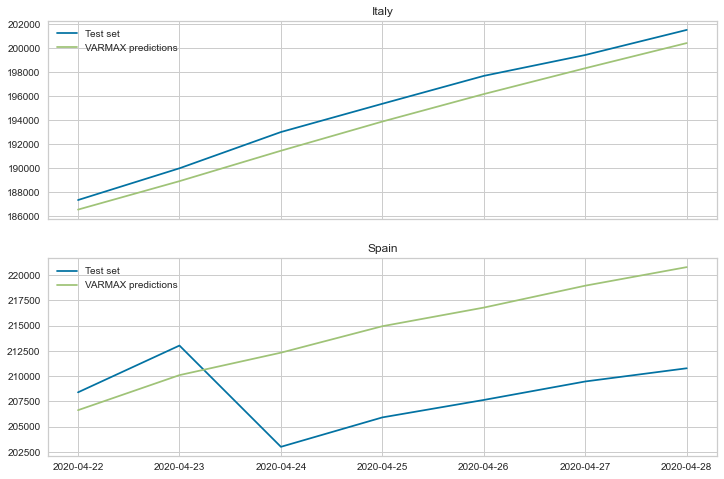

In [52]:
fig,(ax3,ax4) = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax3.plot(c2_test["Italy"],label="Test set")
ax3.plot(varmax_forecast["Italy"],label="VARMAX predictions")
ax3.set_title("Italy")
ax3.legend(loc=2)
ax4.plot(c2_test["Spain"],label="Test set")
ax4.plot(varmax_forecast["Spain"],label="VARMAX predictions")
ax4.set_title("Spain")
ax4.legend(loc=2)
plt.show()